# Data Competition Kelompok PedagangKakiTiga

## Import Package

In [234]:
import pandas as pd
import numpy as np
from datetime import datetime
import nltk
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer

import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from wordcloud import WordCloud

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from nltk import WordNetLemmatizer

from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense, Dropout, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers

from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix

import warnings
warnings.filterwarnings('ignore')

## Import Dataset

In [235]:
df = pd.read_csv("mobil_listrik.csv")

## Preproses Data

### Pemilihan Kolom / Pengurangan Dimensi

In [236]:
data = df[['tanggal', 'text_cleaning', 'sentimen']]

### Mengatasi Missing Values

#### Cek persentase missing values di setiap kolom

In [237]:
missing_percentage = data.isnull().sum() / len(data) * 100

print("Persentase missing values di setiap kolom:\n")
for column in missing_percentage.index:
    print(f"{column}: {missing_percentage[column]:.2f}%")

Persentase missing values di setiap kolom:

tanggal: 0.00%
text_cleaning: 0.13%
sentimen: 0.00%


#### Menghapus baris yang mengandung missing values

In [238]:
data.dropna(inplace = True)

missing_percentage = data.isnull().sum() / len(data) * 100

print("Persentase missing values di setiap kolom:\n")
for column in missing_percentage.index:
    print(f"{column}: {missing_percentage[column]:.2f}%")

Persentase missing values di setiap kolom:

tanggal: 0.00%
text_cleaning: 0.00%
sentimen: 0.00%


#### Mengecek dan menghapus Outlier

In [239]:
data['text_length'] = data['text_cleaning'].str.len()

mean_length = data['text_length'].mean()
std_length = data['text_length'].std()
long_strings = data[data['text_length'] > mean_length + 2 * std_length]
short_strings = data[data['text_length'] < mean_length - 2 * std_length]

uppercase_strings = data[data['text_cleaning'].str.isupper()]
lowercase_strings = data[data['text_cleaning'].str.islower()]

word_counts = Counter(" ".join(data['text_cleaning'].dropna()).split())
uncommon_words = [word for word, count in word_counts.items() if count == 1]

duplicate_strings = data[data.duplicated(subset='text_cleaning', keep=False)]

unusual_chars = data[data['text_cleaning'].str.contains(r'[^a-zA-Z0-9\s]', na=False)]

print("Persentase string yang terlalu panjang :", len(long_strings) / len(data) * 100, "%")
print("Persentase string yang terlalu pendek :", len(short_strings) / len(data) * 100, "%")
print("Persentase string yang semuanya huruf kapital :", len(uppercase_strings) / len(data) * 100, "%")
print("Persentase string yang semuanya huruf kecil :", len(lowercase_strings) / len(data) * 100, "%")
print("Persentase string yang cuma muncul sekali :", len(uncommon_words) / len(word_counts) * 100, "%")
print("Persentase string yang duplikat :", len(duplicate_strings) / len(data) * 100, "%")
print("Persentase string yang mengandung non alfanumerik :", len(unusual_chars) / len(data) * 100, "%")

Persentase string yang terlalu panjang : 3.6303630363036308 %
Persentase string yang terlalu pendek : 0.0 %
Persentase string yang semuanya huruf kapital : 0.0 %
Persentase string yang semuanya huruf kecil : 100.0 %
Persentase string yang cuma muncul sekali : 52.55777720072709 %
Persentase string yang duplikat : 0.132013201320132 %
Persentase string yang mengandung non alfanumerik : 0.0 %


##### Menghapus data duplikat

In [240]:
# Berdasarkan hasil analisis persentase outlier diatas, hanya string yang duplikat yang akan dihapus karena persentasenya kecil

data.drop_duplicates(inplace = True)

### Mengubah tipe data

In [241]:
# Mengubah tipe data tanggal dari string menjadi datetime
data['tanggal'] = pd.to_datetime(data['tanggal']).dt.date
# data.set_index('tanggal', inplace=True)

## Exploratory Data Analysis (EDA)

In [242]:
# Menampilkan Jumlah Baris, nilai yang unik, baris atas dan baris bawah
data.describe()

,text_length
count,1515.000000
mean,99.594719
std,128.805413
min,5.000000
25%,36.500000
50%,64.000000
75%,112.500000
max,1518.000000


In [243]:
# Jumlah Baris dan Kolom
data.shape

(1515, 4)

In [244]:
# Preview 5 Baris Teratas
data.head()

,tanggal,text_cleaning,sentimen,text_length
0,2023-08-06,saran sih bikin harga ionic sama kayak brio ...,positif,69
1,2023-08-04,problem subsidi kualitas diturunin harga dinai...,negatif,104
2,2023-08-04,baik kualitas kembang dulu baik kualitas motor...,positif,68
3,2023-08-04,model jelek kwalitas buruk harga mahal croot,negatif,44
4,2023-08-04,syarat ngaco woy anak muda blom punya ruma...,negatif,145


In [245]:
# Preview 5 Baris Terbawah
df.tail()

,id_komentar,nama_akun,tanggal,text_cleaning,sentimen
1512,UgxJPeJSdLI9a7L_adx4AaABAg,Fish aquspace,2022-09-19 12:30:44+00:00,apa kabar padahal negri luar biasa dapat negara,negatif
1513,UgyHzUNyXtjxftnySNF4AaABAg,Elias Panai,2022-09-19 12:27:18+00:00,antar anak sekolah antar bantu pasar klw jau...,negatif
1514,UgxbIAGGO6Jt50q6wT94AaABAg,Mikhanalont Horassss,2022-09-19 12:23:06+00:00,esemka bangga solo,positif
1515,UgyRNiIV6k2t21V4iMN4AaABAg,ANI ANI SOFIE,2022-09-19 11:48:39+00:00,cerdas orang hny dn pasar itu jln x blom d...,netral
1516,UgyUFUCTdK_RJFsYwQV4AaABAg,La Bold,2022-09-19 11:41:32+00:00,niat beli ev murah malah ikut dinaikin sama pe...,negatif


In [246]:
# Menampilkan Jumlah Sentimen setiap kategori
sentimen_counts = data['sentimen'].value_counts()
fig = px.bar(y= sentimen_counts.values, x=sentimen_counts.index, title='Sentimen')
fig.show()

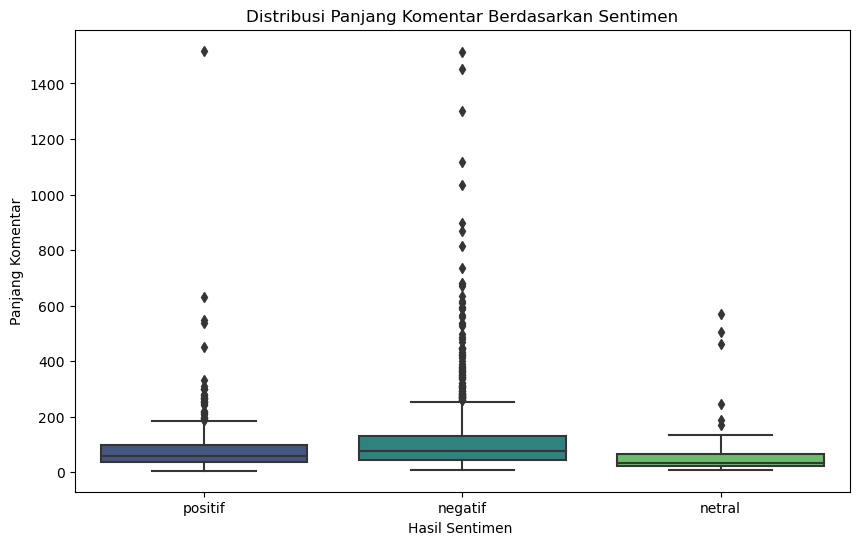

          count        mean         std  min   25%   50%     75%     max
sentimen                                                                
negatif   869.0  117.637514  147.689279  9.0  42.0  75.0  129.00  1513.0
netral    142.0   56.584507   76.900621  6.0  21.0  34.5   66.75   570.0
positif   504.0   80.603175   95.883530  5.0  35.0  57.0   96.00  1518.0


In [247]:
# Distribusi Panjang Komentar Berdasarkan Sentimen (Boxplot)
data['comment_length'] = data['text_cleaning'].str.len()


plt.figure(figsize=(10, 6))
sns.boxplot(x='sentimen', y='comment_length', data=data, palette='viridis')
plt.title('Distribusi Panjang Komentar Berdasarkan Sentimen')
plt.xlabel('Hasil Sentimen ')
plt.ylabel('Panjang Komentar')
plt.show()


comment_length_stats = data.groupby('sentimen')['comment_length'].describe()
print(comment_length_stats)

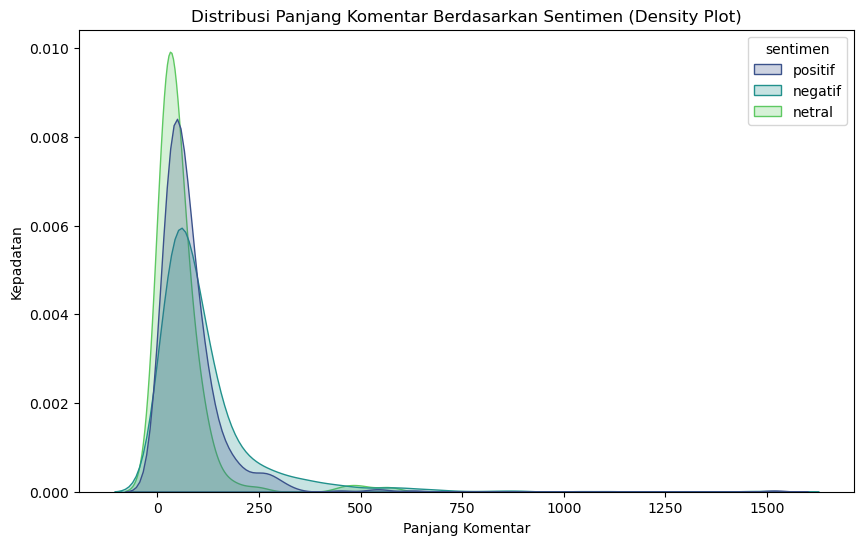

In [248]:
# Distribusi Panjang Komentar Berdasarkan Sentimen (Density Plot)
plt.figure(figsize=(10, 6))
sns.kdeplot(data=data, x='comment_length', hue='sentimen', fill=True, common_norm=False, palette='viridis')
plt.title('Distribusi Panjang Komentar Berdasarkan Sentimen (Density Plot)')
plt.xlabel('Panjang Komentar')
plt.ylabel('Kepadatan')
plt.show()

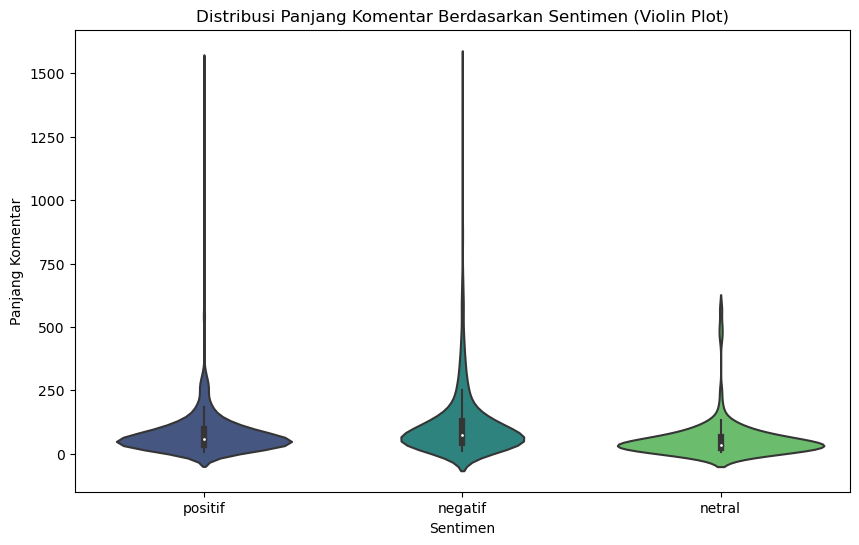

In [249]:
# Distribusi Panjang Komentar Berdasarkan Sentimen (Violin Plot)
plt.figure(figsize=(10, 6))
sns.violinplot(x='sentimen', y='comment_length', data=data, palette='viridis')
plt.title('Distribusi Panjang Komentar Berdasarkan Sentimen (Violin Plot)')
plt.xlabel('Sentimen')
plt.ylabel('Panjang Komentar')
plt.show()

### Distribusi Sentimen per bulan

#### Proses mengubah dataset untuk digabungkan per bulan

In [250]:
df_groupby = pd.get_dummies(data, columns = ['sentimen'], dtype = int)
df_groupby.reset_index(inplace = True)

In [251]:
df_groupby['tanggal'] = pd.to_datetime(df_groupby['tanggal']).dt.date
df_groupby.set_index('tanggal', inplace=True)

In [252]:
df_groupby.index = pd.to_datetime(df_groupby.index)

df_groupby_month = df_groupby.groupby(pd.Grouper(freq='M')).sum()

#### Visualisasi

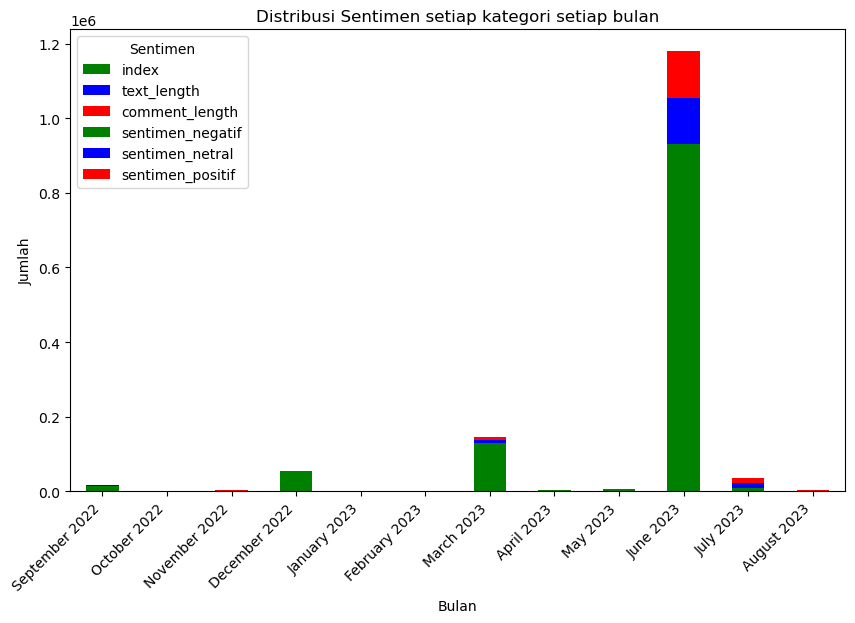

In [253]:
# Visualisasi Distribusi sentimen setiap kategori setiap bulan
df_groupby_month.index = pd.to_datetime(df_groupby_month.index)
df_groupby_month.index = df_groupby_month.index.strftime('%B %Y')

df_groupby_month.plot(kind='bar', stacked=True, figsize=(10, 6), color=['green', 'blue', 'red'])

plt.title('Distribusi Sentimen setiap kategori setiap bulan')
plt.xlabel('Bulan')
plt.ylabel('Jumlah')
plt.legend(title='Sentimen')
plt.xticks(rotation=45, ha='right')

plt.show()

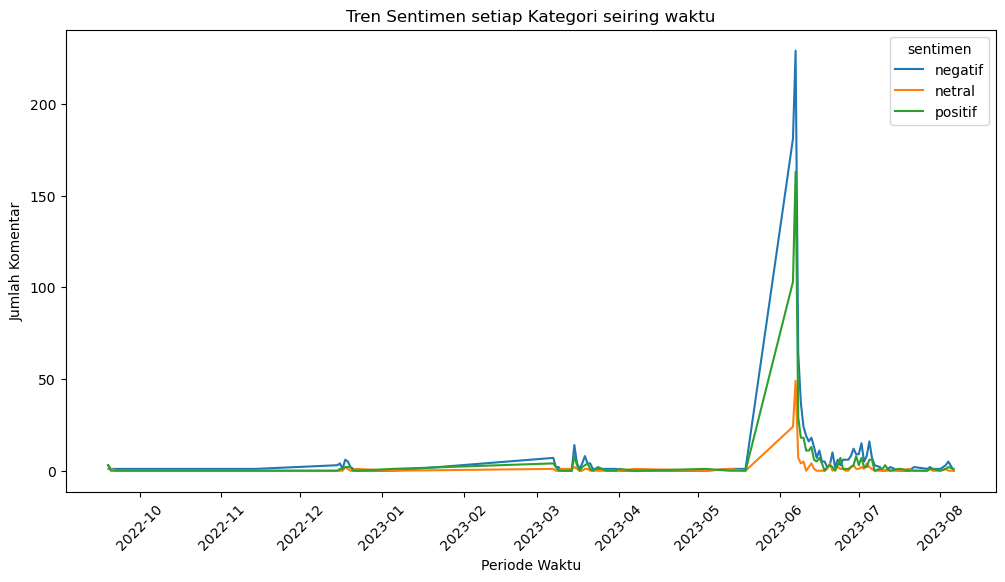

In [254]:
# Visualisasi tren kategori setiap sentimen berdasarkan waktu per bulan
data['tanggal'] = pd.to_datetime(data['tanggal'])

sentiment_over_time = data.groupby([data['tanggal'].dt.date, 'sentimen']).size().unstack().fillna(0)

plt.figure(figsize=(12, 6))
sentiment_over_time.plot(kind='line', ax=plt.gca())
plt.title('Tren Sentimen setiap Kategori seiring waktu')
plt.xlabel('Periode Waktu')
plt.ylabel('Jumlah Komentar')
plt.xticks(rotation=45)
plt.show()

### World Cloud / Awan Kata untuk kata yang paling banyak muncul di komentar

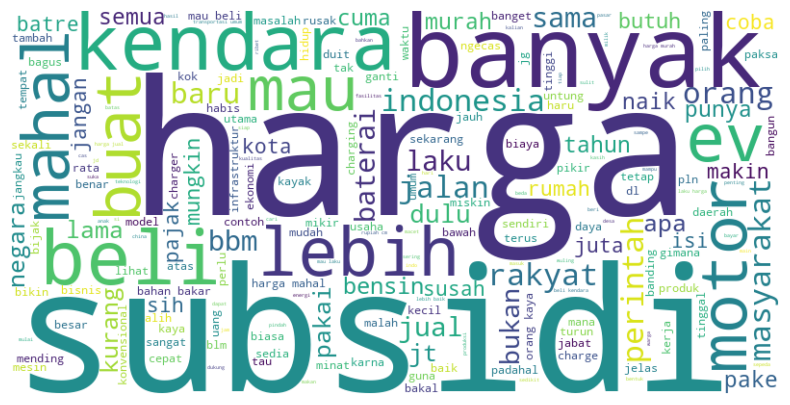

In [255]:
# Word Cloud untuk kata-kata yang paling sering muncul
all_text = ' '.join(data['text_cleaning'])

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## Modeling dan Evaluasi

### NLP

In [256]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\untu0\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\untu0\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\untu0\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [257]:
data = data.reset_index()
data = data.drop(columns = 'tanggal')

In [258]:
le = LabelEncoder()
le.fit(['negatif','netral', 'positif'])
data['sentimen'] = le.transform(data['sentimen'])

In [259]:
stop_words = set(stopwords.words('indonesian'))
lemmatizer = WordNetLemmatizer()

In [260]:
def nlp(teks):
  teks  = word_tokenize(teks)
  teks = [kata for kata in teks if kata.lower() not in stop_words]
  return teks

In [261]:
data['text_cleaning'] = data['text_cleaning'].apply(nlp)
data['text_cleaning']

0       [saran, sih, bikin, harga, ionic, kayak, brio,...
1       [problem, subsidi, kualitas, diturunin, harga,...
2       [kualitas, kembang, kualitas, motor, motor, pa...
3       [model, jelek, kwalitas, buruk, harga, mahal, ...
4       [syarat, ngaco, woy, anak, muda, blom, rumah, ...
                              ...                        
1510                               [kabar, negri, negara]
1511    [anak, sekolah, bantu, pasar, klw, klw, jebak,...
1512                               [esemka, bangga, solo]
1513    [cerdas, orang, hny, dn, pasar, jln, x, blom, ...
1514    [niat, beli, ev, murah, dinaikin, perintah, ra...
Name: text_cleaning, Length: 1515, dtype: object

### Split

In [262]:
x = data['text_cleaning']
y = data['sentimen']

In [263]:
q70 = int(len(x)*.7)
q80 = int(len(x)*.8)

x_train, x_val, x_test = x[:q70], x[q70:q80], x[q80:]
y_train, y_val, y_test = y[:q70], y[q70:q80], y[q80:]

In [264]:
#Berfungsi untuk mendapakan vocab yang unik
vocabulary = set()
for text in x:
  vocabulary.update(text)

In [265]:
word_to_index = {word: index for index, word in enumerate(vocabulary)}

In [266]:
def convert_to_indices(tokens):
  return [word_to_index[token] for token in tokens]

x1 = x.apply(convert_to_indices).to_list()
x_train = x_train.apply(convert_to_indices).to_list()
x_val = x_val.apply(convert_to_indices).to_list()
x_test = x_test.apply(convert_to_indices).to_list()

In [267]:
x_train = pad_sequences(x_train)
x_val = pad_sequences(x_val)
x_test = pad_sequences(x_test)
x_train.shape, x_val.shape, x_test.shape

((1060, 227), (152, 74), (303, 86))

In [268]:
x2 = pad_sequences(x1,  padding = "post")
X_train, X_val, X_test = x2[:q70], x2[q70:q80], x2[q80:]
X_train.shape, X_val.shape, X_test.shape

((1060, 227), (152, 227), (303, 227))

In [269]:

pipeline  = Pipeline([
    ('scaler', MinMaxScaler()),
    ('RFC', RandomForestClassifier())
])

param_grid = {
    'RFC__n_estimators': [10, 50, 100, 150, 200],
    'RFC__max_depth': [None,5, 10, 20, 30]
}

grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=3)
grid_search.fit(X_train, y_train)

print(f'Best Parameters: {grid_search.best_params_}')
print(f'Best Validation Score: {grid_search.best_score_}')


Best Parameters: {'RFC__max_depth': 20, 'RFC__n_estimators': 150}
Best Validation Score: 0.5792240841215729


In [270]:
test_predictions = grid_search.predict(X_test)
RFC_acc = accuracy_score(y_test, test_predictions)
print(f'Test Accuracy Random Forest: {RFC_acc}')

Test Accuracy Random Forest: 0.5676567656765676


In [271]:

pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('NB', MultinomialNB())
])


param_grid = {
    'NB__alpha': [1e-3, 1e-2, 1e-1, 1, 10],
    'NB__fit_prior': [True, False]
}


grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

print(f'Best Parameters: {grid_search.best_params_}')
print(f'Best Train Score: {grid_search.best_score_}')

val_predictions = grid_search.predict(X_val)

accuracy = accuracy_score(y_val, val_predictions)
print(f'Val Accuracy with GridSearchCV: {accuracy:.4f}')

Best Parameters: {'NB__alpha': 10, 'NB__fit_prior': True}
Best Train Score: 0.5613207547169812
Val Accuracy with GridSearchCV: 0.6053


In [272]:
test_predictions = grid_search.predict(X_test)
nb_acc = accuracy_score(y_test, test_predictions)
print(f'Test Accuracy Naive Bayes: {nb_acc}')

Test Accuracy Naive Bayes: 0.5841584158415841


In [273]:
scaler = StandardScaler()

LR = LogisticRegression(max_iter=500, random_state=42)
pipeline = Pipeline([
    ('scaler', scaler),
    ('LR', LR)
])

param_grid = {
    'LR__solver': ['lbfgs', 'newton-cg', 'sag', 'saga']
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

print(f'Best Parameters: {grid_search.best_params_}')
print(f'Best Train Score: {grid_search.best_score_}')


Best Parameters: {'LR__solver': 'sag'}
Best Train Score: -1.5113207547169811


In [274]:
val_predictions = grid_search.predict(X_val)
print(f'Val Accuracy LR: {accuracy_score(y_val, val_predictions)}')
lr_acc = accuracy_score(y_test, test_predictions)
test_predictions = grid_search.predict(X_test)
print(f'Test Accuracy LR: {lr_acc}')

Val Accuracy LR: 0.6052631578947368
Test Accuracy LR: 0.5841584158415841


In [275]:
y_train = to_categorical(y_train, num_classes=3)
y_val = to_categorical(y_val, num_classes=3)

In [276]:
model = Sequential([
    Embedding(input_dim=len(vocabulary), output_dim=64),
    GRU(9,kernel_regularizer=regularizers.l2(0.1)),
    Dropout(0.6),
    Dense(3, activation='softmax', kernel_regularizer=regularizers.l2(0.1))
])
model.build(input_shape=(None, None))

In [277]:
model.compile(optimizer=Adam(learning_rate=0.01),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_9 (Embedding)         │ (None, None, 64)       │       233,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_5 (GRU)                     │ (None, 9)              │         2,025 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 9)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 3)              │            30 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 235,335 (919.28 KB)

 Trainable params: 235,335 (919.28 KB)

 Non-trainable params: 0 (0.00 B)

In [278]:
history = model.fit(x_train, y_train,
                    epochs=30,
                    validation_data=(x_val, y_val))

Epoch 1/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - accuracy: 0.4954 - loss: 3.1601 - val_accuracy: 0.6053 - val_loss: 0.9908
Epoch 2/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.5718 - loss: 1.0139 - val_accuracy: 0.6053 - val_loss: 0.8753
Epoch 3/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.5639 - loss: 0.9653 - val_accuracy: 0.6053 - val_loss: 0.8698
Epoch 4/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.6022 - loss: 0.8858 - val_accuracy: 0.6053 - val_loss: 0.8735
Epoch 5/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - accuracy: 0.5550 - loss: 0.9508 - val_accuracy: 0.6053 - val_loss: 0.8606
Epoch 6/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - accuracy: 0.5559 - loss: 0.9294 - val_accuracy: 0.6053 - val_loss: 0.8613
Epoch 7/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - accuracy: 0.5736 - loss: 0.9019 - val_accuracy: 0.6053 - val_loss: 0.8615
Epoch 8/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.5600 - loss: 0.9383 - val_accuracy: 0.6053 - v

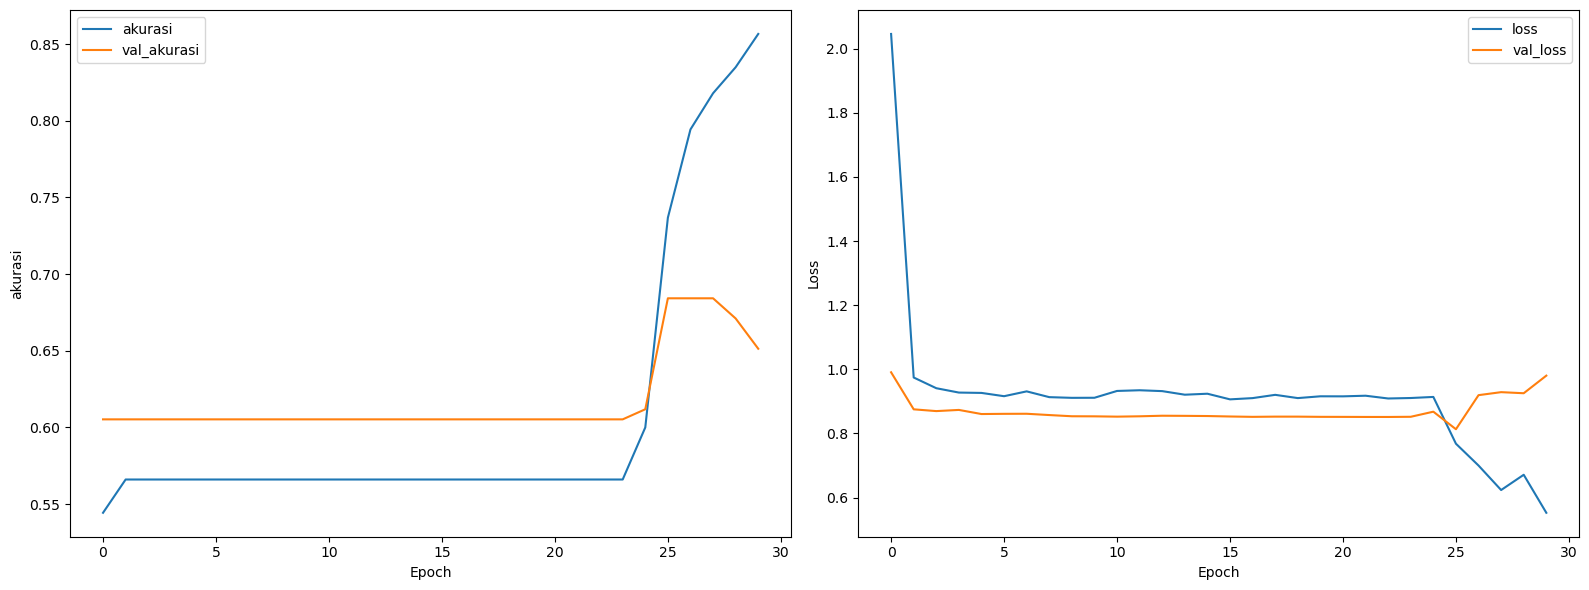

In [279]:
cek_1 = history

plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)

plt.plot(cek_1.history['accuracy'], label='akurasi')
plt.plot(cek_1.history['val_accuracy'], label='val_akurasi')
plt.xlabel('Epoch')
plt.ylabel('akurasi')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(cek_1.history['loss'], label='loss')
plt.plot(cek_1.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
              precision    recall  f1-score   support

           0       0.71      0.71      0.71       177
           1       0.00      0.00      0.00        30
           2       0.46      0.60      0.52        96

    accuracy                           0.60       303
   macro avg       0.39      0.44      0.41       303
weighted avg       0.56      0.60      0.58       303



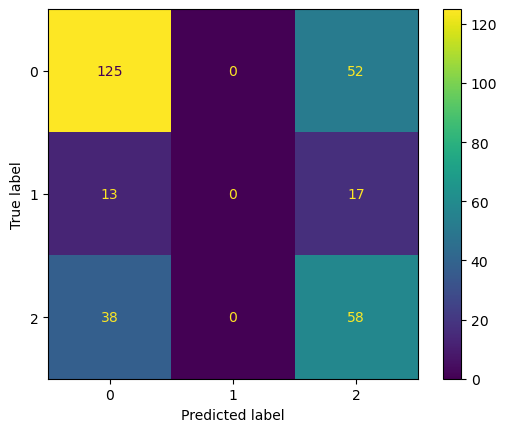

In [280]:
GRU_pred = model.predict(x_test)
GRU_pred_classes = np.argmax(GRU_pred, axis=1)
GRU_acc = accuracy_score(GRU_pred_classes, y_test)
print(classification_report(y_test,  GRU_pred_classes))

cm = confusion_matrix(y_test, GRU_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [281]:
model = Sequential([
    Embedding(input_dim=len(vocabulary), output_dim=32),
    Dropout(0.5),
    LSTM(9, kernel_regularizer=regularizers.l2(0.01)),
    Dropout(0.5),
    Dense(3, activation='softmax', kernel_regularizer=regularizers.l2(0.01))
])
model.build(input_shape=(None, None))

In [282]:
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_10 (Embedding)        │ (None, None, 32)       │       116,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, None, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 9)              │         1,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 9)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 3)              │            30 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 118,182 (461.65 KB)

 Trainable params: 118,182 (461.65 KB)

 Non-trainable params: 0 (0.00 B)

In [283]:
history = model.fit(x_train, y_train,
                    epochs=30,
                    validation_data=(x_val, y_val))

Epoch 1/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - accuracy: 0.4743 - loss: 1.4525 - val_accuracy: 0.6053 - val_loss: 1.2907
Epoch 2/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.5466 - loss: 1.2803 - val_accuracy: 0.6053 - val_loss: 1.1216
Epoch 3/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.5490 - loss: 1.1644 - val_accuracy: 0.6053 - val_loss: 1.0294
Epoch 4/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.5467 - loss: 1.0911 - val_accuracy: 0.6053 - val_loss: 0.9701
Epoch 5/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.5650 - loss: 1.0162 - val_accuracy: 0.6053 - val_loss: 0.9198
Epoch 6/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.5455 - loss: 1.0280 - val_accuracy: 0.6053 - val_loss: 0.9088
Epoch 7/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.5567 - loss: 0.9667 - val_accuracy: 0.6118 - val_loss: 0.8972
Epoch 8/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.5721 - loss: 0.9253 - val_accuracy: 0.6053 - v

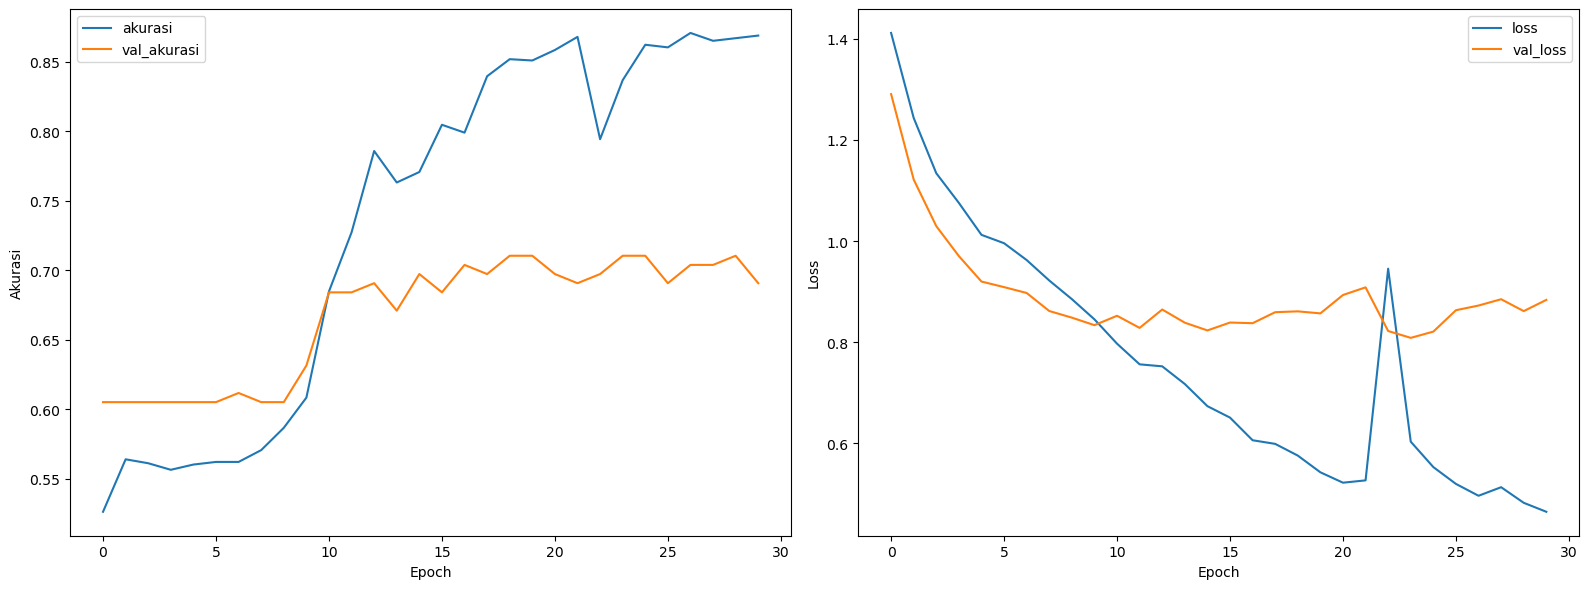

In [284]:
cek_1 = history

plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)

plt.plot(cek_1.history['accuracy'], label='akurasi')
plt.plot(cek_1.history['val_accuracy'], label='val_akurasi')
plt.xlabel('Epoch')
plt.ylabel('Akurasi')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(cek_1.history['loss'], label='loss')
plt.plot(cek_1.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
              precision    recall  f1-score   support

           0       0.75      0.77      0.76       177
           1       0.00      0.00      0.00        30
           2       0.53      0.68      0.60        96

    accuracy                           0.66       303
   macro avg       0.43      0.48      0.45       303
weighted avg       0.61      0.66      0.63       303



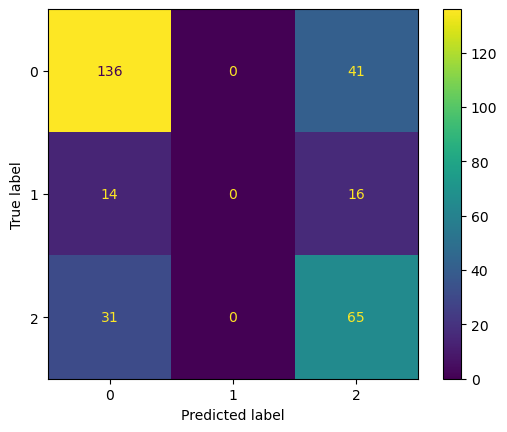

In [285]:
LSTM_pred = model.predict(x_test)
LSTM_pred_classes = np.argmax(LSTM_pred, axis=1)
LSTM_acc = accuracy_score(LSTM_pred_classes, y_test)

print(classification_report(y_test,  LSTM_pred_classes))

cm = confusion_matrix(y_test, LSTM_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [286]:
hasil = pd.DataFrame({
    "Algoritma" : ["Random Forest Classifier", "Multinomial Naive Bayes", "Logistic Regression", "GRU", "LSTM"],
    "Akurasi" : [RFC_acc,nb_acc,lr_acc,GRU_acc,LSTM_acc]})
hasil_sorted = hasil.sort_values(by="Akurasi", ascending=False)
hasil_sorted

,Algoritma,Akurasi
4,LSTM,0.663366
3,GRU,0.603960
1,Multinomial Naive Bayes,0.584158
2,Logistic Regression,0.584158
0,Random Forest Classifier,0.567657
